Import the neccessary libaries

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [2]:
warnings.filterwarnings("ignore")

Data Collection (Chevron Stock)

In [3]:
# Define the stock ticker (Chevron) and the date range
TICKER = "CVX"
START_DATE = "2020-01-01"
END_DATE = "2025-01-01"

In [ ]:
print(f"----- Downloading Historical Stock Data for Chevron -----")
# Use yf.download to pull historical stock price data
# We only use the "Close" price for prediction as it accounts for dividend and splits
data = yf.download(TICKER,start=START_DATE,end=END_DATE)

----- Downloading Historical Stock Data for Chevron -----


[*********************100%***********************]  1 of 1 completed


In [7]:
# Check the first few rows of the downloaded data
data.head()

Price,Close,High,Low,Open,Volume
Ticker,CVX,CVX,CVX,CVX,CVX
Date,,,,,
2020-01-02,93.955620,94.110366,93.444947,93.475897,5205000
2020-01-03,93.630661,94.953761,93.421747,94.226441,6360900
2020-01-06,93.313408,94.141313,93.104500,93.808603,9953000
2020-01-07,92.121857,92.640269,91.123727,92.090906,7856900
2020-01-08,91.069565,92.145067,91.030881,91.727251,7295900


Data Preprocessing

In [8]:
# Check for missing values
data_missing = data.isnull().sum()
print("----- Missing Values -----")
print(data_missing)

----- Missing Values -----
Price   Ticker
Close   CVX       0
High    CVX       0
Low     CVX       0
Open    CVX       0
Volume  CVX       0
dtype: int64


In [9]:
# Check for duplicated rows
data_duplicated = data.duplicated().sum()
print("----- Duplicated Rows -----")
print(data_duplicated)

----- Duplicated Rows -----
0


Feature Engineering

In [11]:
# The goal is to predict the price on "day N" using information from "day N-1", N-2 etc
# This converts the time-series problem into a standard supervised problem

# Target Variable (y): The price we want to predict (Close shifted one daya forward)
# We shift the target up by -1 to predict the next day's price
data["Target"] = data["Close"].shift(-1)

In [12]:
# Feature (X): Lagged prices (past day prices) and moving averages (trend indicators)
# Feature 1: Price 1 day ago (lag 1)
data["Lag_1"] = data["Close"].shift(1)

# Feature 2: Price days ago (lag 7, roughly a week)
data["Lag_7"] = data["Close"].shift(7)

In [13]:
# Feature 3: 5-Day Simple moving average (SMA - short term trend)
data["SMA_5"] = data["Close"].rolling(window=5).mean()

# Feature 4: 20-Day Simple moving average (SMA - medium term trend)
data["SMA_20"] = data["Close"].rolling(window=20).mean()

In [14]:
# Drop rows with NaN values created by shifting and rolling calculations
# The first 20 days will have NaNs due to SMA_20, which is necessary to drop.
data.dropna(inplace=True)

In [15]:
# Define the features (X) and the target (y)
features = ["Lag_1","Lag_7","SMA_5","SMA_20"]
X = data[features]
y = data["Target"]

Data Visualization before training

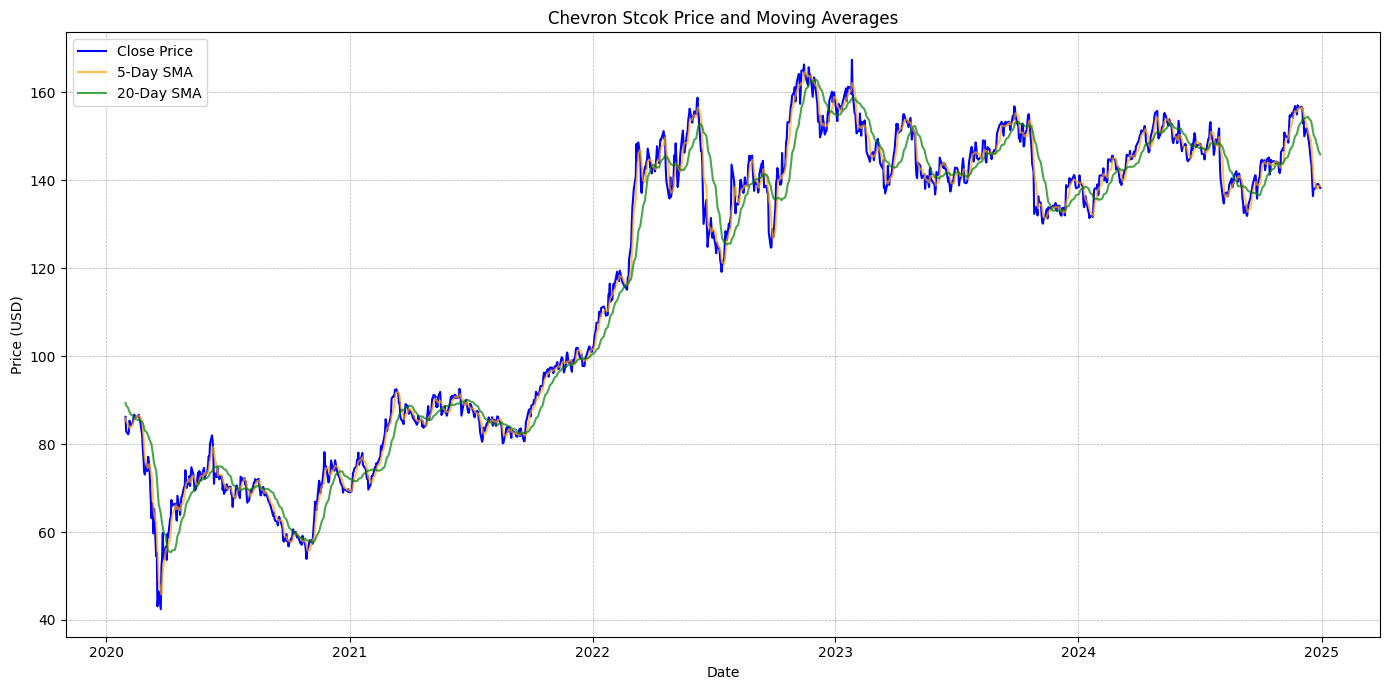

In [16]:
plt.figure(figsize=(14,7))
# Plot the historical Close price
plt.plot(data.index,data["Close"],label="Close Price",color="blue")
# Plot the 5-day moving average to show the short term trend
plt.plot(data.index,data["SMA_5"],label="5-Day SMA",color="orange",alpha=0.7)
# Plot the 20-day moving average to show the medium-term trend
plt.plot(data.index,data["SMA_20"],label="20-Day SMA",color="green",alpha=0.7)
plt.title("Chevron Stcok Price and Moving Averages")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True,which="both",linestyle="--",linewidth=0.5)
# Use tight_layout to ensure all elemnts fit the plot area
plt.tight_layout()
plt.show() # Display the plot

Data Splitting

In [17]:
# Split the data into training and testing sets
# Using a time-series split (no shuffling) is cruical for financial data
# We'll use 80% for training and 20% for testing

split_point = int(len(X) * 80)
X_train,X_test = X[:split_point],X[split_point:]
y_train,y_test = y[:split_point],y[split_point:]